In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [6]:
def plot_cohort(orders, date_from, date_to):
    orders = orders[(orders['order_date'] < date_to) & (date_from < orders['order_date'])]
    orders = orders[['customer_id', 'order_date', 'id']].drop_duplicates()
    orders['order_month'] = orders['order_date'].dt.to_period('M')
    orders['cohort'] = orders.groupby('customer_id')['order_date'].transform('min').dt.to_period('M')
    df_cohort = orders.groupby(['cohort', 'order_month']).agg(n_customers = ('customer_id', 'nunique')).reset_index(drop = False)
    df_cohort['period_number'] = (df_cohort['order_month'] - df_cohort['cohort']).apply(attrgetter('n'))
    
    cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
    cohort_size = cohort_pivot.iloc[:,0]
    
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
        sns.heatmap(retention_matrix, 
                    mask=retention_matrix.isnull(), 
                    annot=True, 
                    fmt='.0%', 
                    cmap='RdYlGn', 
                    ax=ax[1])
        ax[1].set_title(f'Ежемесячные когорты пользователей, период {date_from} - {date_to}', fontsize=16)
        ax[1].set(xlabel='номер периода',
                  ylabel='')
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])

        fig.tight_layout()

Загрузим основные имеющиеся данные

In [7]:
customers = pd.read_csv('customers.csv')
orders = pd.read_csv('orders.csv')

In [8]:
customers

,id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord
...,...,...,...,...,...
788,CJ-11875,Carl Jackson,Corporate,Pennsylvania,Philadelphia
789,RS-19870,Roy Skaria,Home Office,Iowa,Burlington
790,SC-20845,Sung Chung,Consumer,Illinois,Arlington Heights
791,RE-19405,Ricardo Emerson,Consumer,Ohio,Kent


In [9]:
orders

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376
...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368
5005,169320,2017-07-23,Second,LH-16900,171.430
5006,169488,2017-09-07,First,AA-10375,56.860
5007,169502,2017-08-28,Standard,MG-17650,113.410


In [12]:
completed = pd.merge(orders, customers, how = 'left', left_on = 'customer_id', right_on = 'id')
completed['order_date'] = pd.to_datetime(completed['order_date'],infer_datetime_format=True)
completed.drop(['id_y'], axis = 1, inplace = True)
completed.rename(columns = {'id_x': 'id'}, inplace = True)
completed.dropna(subset=['customer_id'], inplace=True)

completed

,id,order_date,ship_mode,customer_id,sales,name,segment,state,city
0,100006,2014-09-07,Standard,DK-13375,377.970,Dennis Kane,Consumer,Ohio,Marion
1,100090,2014-07-08,Standard,EB-13705,699.192,Ed Braxton,Corporate,Ohio,Akron
2,100293,2014-03-14,Standard,NF-18475,91.056,Neil Franzosisch,Home Office,Illinois,Rockford
3,100328,2014-01-28,Standard,JC-15340,3.928,Jasper Cacioppo,Consumer,California,Los Angeles
4,100363,2014-04-08,Standard,JM-15655,21.376,Jim Mitchum,Corporate,New Jersey,Bridgeton
...,...,...,...,...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368,Jack O'Briant,Corporate,Pennsylvania,Philadelphia
5005,169320,2017-07-23,Second,LH-16900,171.430,Lena Hernandez,Consumer,Delaware,Dover
5006,169488,2017-09-07,First,AA-10375,56.860,Allen Armold,Consumer,Arizona,Mesa
5007,169502,2017-08-28,Standard,MG-17650,113.410,Matthew Grinstein,Home Office,Pennsylvania,Philadelphia


Важными метриками в данном случае можно назвать:

- Monthly Retention rate за 2016 и 2017 год
- Выручка в различных категориях

В магазине представлены товары из 3 категорий: *Consumer, Corporate, Home Office*. Посмотрим, как варьируются цены на данные товары в магазине.

In [13]:
# Посмотрим, как варьируются цены на различные товары в зависимости от сегмента
# Как видно, товары всех сегментов находятся в одном ценовом диапозоне

completed.groupby('segment')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
Consumer,2586.0,449.111116,901.908683,0.852,38.3025,154.670,492.84625,14052.480
Corporate,1514.0,466.411075,909.825806,0.556,39.0180,158.252,546.83400,18336.740
Home Office,909.0,472.665730,1153.985052,1.810,34.0000,142.344,505.68600,23661.228


In [14]:
completed.groupby('segment')['sales'].count()

segment
Consumer       2586
Corporate      1514
Home Office     909
Name: sales, dtype: int64

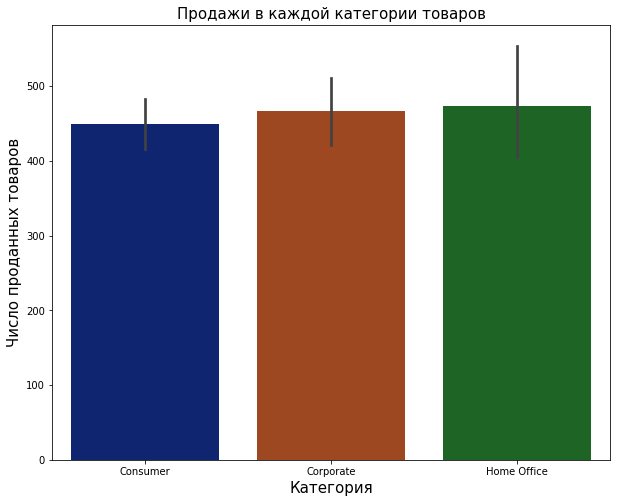

In [15]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.barplot(x = completed['segment'], y = completed['sales'], palette ='dark')
plt.title('Продажи в каждой категории товаров', fontsize = 15)
plt.xlabel('Категория', fontsize = 15)
plt.ylabel('Число проданных товаров', fontsize = 15)
plt.show()

Видим, что чаще всего продаются товары из категории Home Office, меньше всего - Consumer.

С помощью когортного анализа изучим, как изменялся retention в течение 2017 и 2016 года.

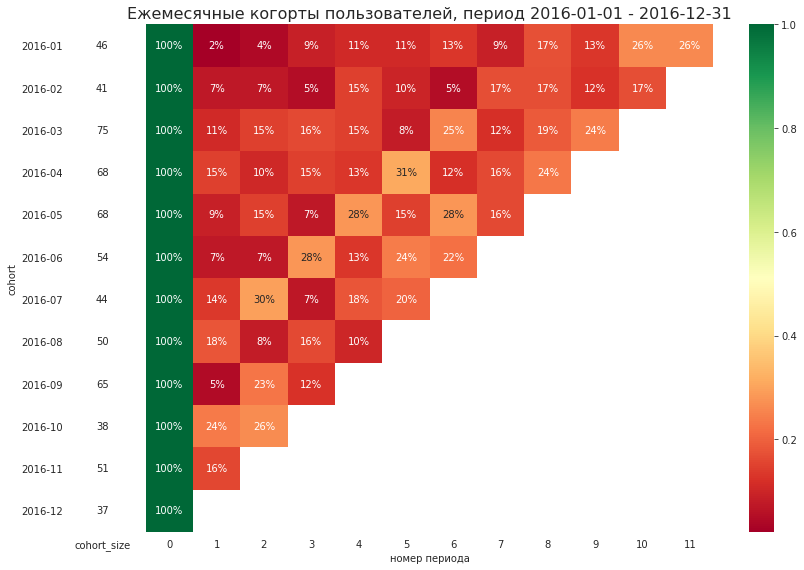

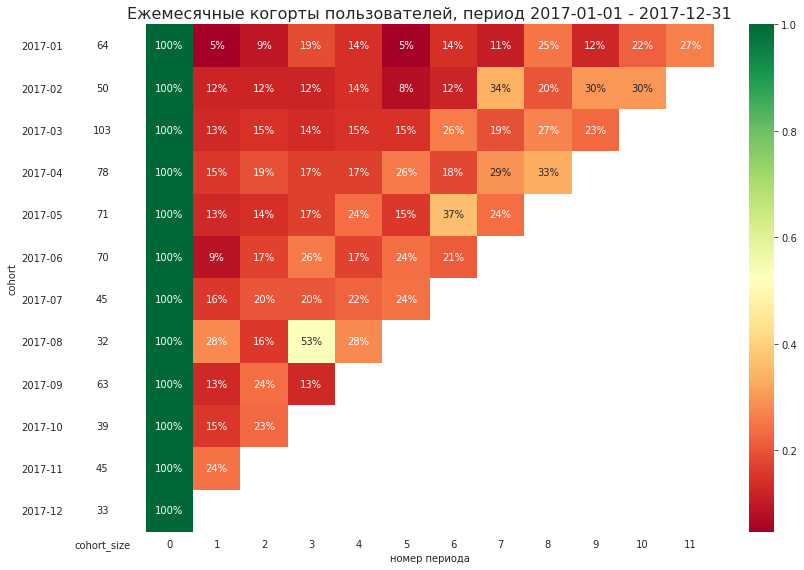

In [16]:
plot_cohort(completed, '2016-01-01', '2016-12-31')
plot_cohort(completed, '2017-01-01', '2017-12-31')

На основании данных диаграмм можно сделать следующие выводы:
    
- Для большинства групп retention увеличивается к концу периода. Это можно объяснить тем, что люди в конце года возвращаются, чтобы купить подарки (сезонность).
- Относительный retention по сравнению с 2016 годом в 2017 году увеличился - следовательно, гипотеза не может быть подтверждена. 

In [55]:
revenue = completed[['order_date', 'sales', 'segment']]
revenue['order_month'] = revenue['order_date'].dt.to_period('M')
sales1417 = revenue[revenue['order_month'] > '2014-01'].groupby('order_month').sum()

<ipython-input-55-be1f53f91231>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenue['order_month'] = revenue['order_date'].dt.to_period('M')


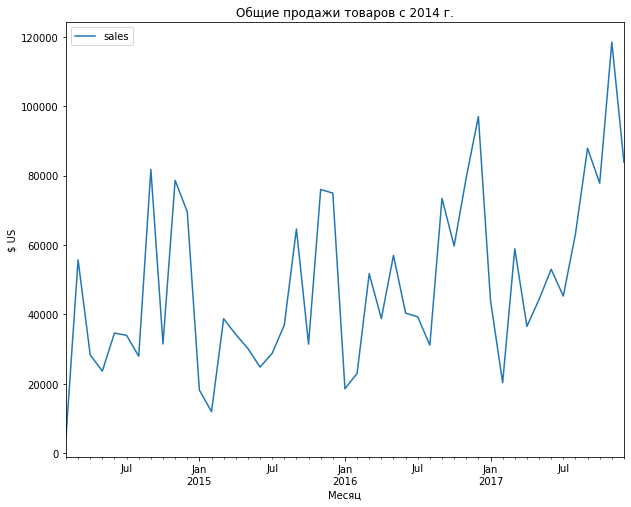

In [57]:
sales1417.reset_index()
sales1417.plot(ylabel = '$ US', xlabel = 'Месяц', title = 'Общие продажи товаров с 2014 г.')
plt.show()

Видим, что общая прибыль компании выросла, существует тренд на рост, при этом наблюдается ясно выраженная сезонность. Посмотрим, имеется ли рост в каждом из сегментов.

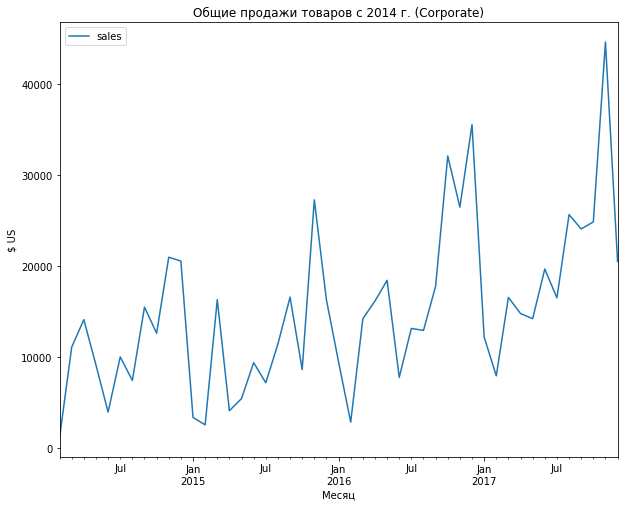

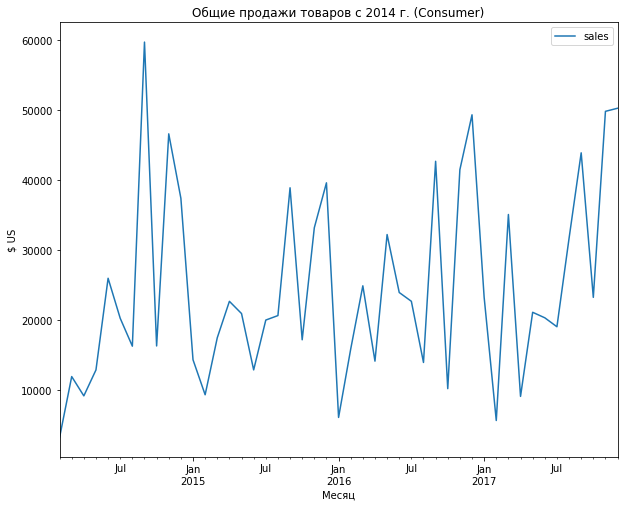

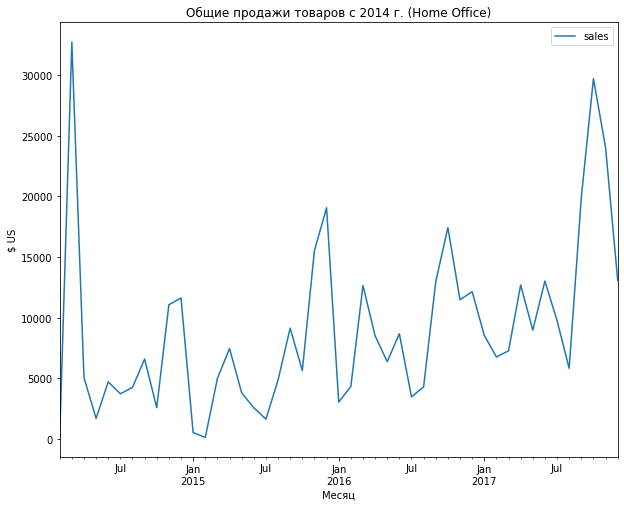

In [63]:
sales_segments_c = revenue[(revenue['order_month'] > '2014-01') & (revenue['segment'] == 'Corporate')].groupby('order_month').sum()
sales_segments_c.plot(ylabel = '$ US', xlabel = 'Месяц', title = 'Общие продажи товаров с 2014 г. (Corporate)')

sales_segments_cons = revenue[(revenue['order_month'] > '2014-01') & (revenue['segment'] == 'Consumer')].groupby('order_month').sum()
sales_segments_cons.plot(ylabel = '$ US', xlabel = 'Месяц', title = 'Общие продажи товаров с 2014 г. (Consumer)')

sales_segments_ho = revenue[(revenue['order_month'] > '2014-01') & (revenue['segment'] == 'Home Office')].groupby('order_month').sum()
sales_segments_ho.plot(ylabel = '$ US', xlabel = 'Месяц', title = 'Общие продажи товаров с 2014 г. (Home Office)')

plt.show()

Как видно, рост прибыли наблюдается только в сегменте Corporate (незначительно в Home Office).

Действительно, возвращаемость пользователей в магазине стало выше. Проверим, как часто появляются новые пользователи.

In [83]:
users = completed[['order_date', 'customer_id', 'state']]
users['order_date'] = users['order_date'].dt.to_period('M')
users = users.drop_duplicates(subset = ['customer_id'])

<ipython-input-83-e66987aa3a74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['order_date'] = users['order_date'].dt.to_period('M')


In [84]:
users

,order_date,customer_id,state
0,2014-09,DK-13375,Ohio
1,2014-07,EB-13705,Ohio
2,2014-03,NF-18475,Illinois
3,2014-01,JC-15340,California
4,2014-04,JM-15655,New Jersey
...,...,...,...
3382,2017-05,MK-18160,Florida
3780,2017-12,CS-12460,Georgia
4161,2017-03,RM-19750,New York
4397,2015-04,MO-17950,Texas


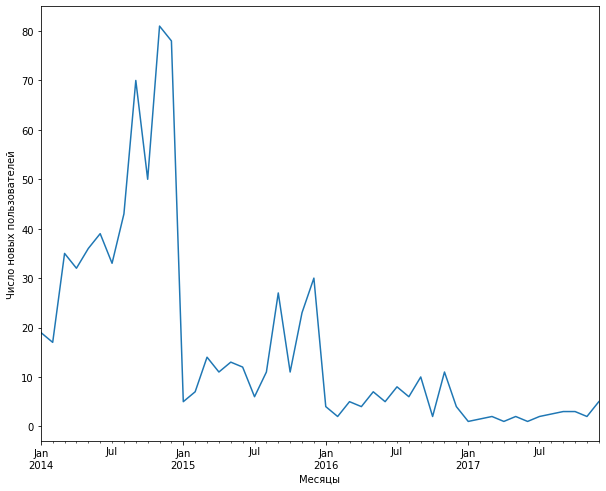

In [90]:
users.groupby('order_date')['customer_id'].count().plot(xlabel = 'Месяцы', ylabel = 'Число новых пользователей')
plt.show()

Как видно, самый активный период  был с 2014-2015 годы - тогда в появилось самое большое число уникальных пользователей. При этом общее число привлеченных в 2017 году пользователей оказалось минимальным за все время - всего 21 человек.

In [96]:
users[users['order_date'] > '2017-01']['customer_id'].count()

21

**Общий вывод по заданию:**

1. Гипотеза руководителя не подтвердилась - пользователи не уходят больше, чем в 2016 году, в среднем retention растет.
2. Основная проблема - маленькое число привлекаемых пользователей. За весь 2017 год было привлечено меньше покупателей, чем в один месяц 2014 года. Иначе, мы привлекаем меньшее число пользователей, которые более лояльны к нашему бизнесу.
3. Общие продажи растут - но при этом только в одном сегменте Corporate.